In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Instructions
To run this notebook, you will need to download the Brainspan "Developmental Transcriptome Dataset", which can be found here: https://www.brainspan.org/static/download.html

Note where you save this data. May be simplest to put it in the ./data directory.



# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [2]:
# Where to save figures
fig_dir = './figures/'
#bspan_dir = './data/'
bspan_dir = '/Users/jacobv/Science/Brainspan/genes_matrix_csv/'

In [3]:
# df = pandas.read_csv(os.path.join(bspan_dir,'gene_expression_original.csv',)) # expression data
# rmd = pandas.read_csv(os.path.join(bspan_dir,'gene_metadata_original.csv')) # rows metadata
# cmd = pandas.read_csv(os.path.join(bspan_dir,'samples_metadata.csv')) # columns metadata
df = pandas.read_csv(os.path.join(bspan_dir,'expression_matrix.csv',),header=None,
                    index_col=0) # expression data
rmd = pandas.read_csv(os.path.join(bspan_dir,'rows_metadata.csv'),index_col=0) # rows metadata
cmd = pandas.read_csv(os.path.join(bspan_dir,'columns_metadata.csv'),index_col=0) # columns metadata

In [4]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [5]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [6]:
df.shape

(52376, 524)

In [7]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

In [8]:
df.shape

(47384, 524)

# Harmonize datasets

#### Load component data

In [9]:
# We created this notebook in NB3_PLS_ModelExploration
all_comps = pandas.read_csv('./tables/all_comps_ROTATION.csv',index_col=0)

#### harmonize genes

In [10]:
shared = list(set(rmd.gene_symbol.values) & set(all_comps.gene_symbol))
len(shared)

13750

In [11]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13750, 524)

In [12]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
#gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


In [13]:
gdf = pandas.DataFrame(cmd,copy=True)

In [14]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [15]:
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

In [13]:
#MinMaxScaler().fit_transform(gxp)

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cross_decomposition import PLSRegression

# fit model
shared = set(hbigdf.columns) & set(gxp.index)
indf = pandas.DataFrame(hbigdf[shared],copy=True)
pcamod = PCA(n_components=100, random_state=123).fit(indf)
pca_tfm = pandas.DataFrame(pcamod.transform(indf),index = hgdf.index)
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm,full_y)

PLSRegression(n_components=3)

In [17]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs',]
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [18]:
gxp.columns = [int(x) for x in gxp.columns]
mmmod = MinMaxScaler().fit(gxp.T.loc[gdf[gdf.Age_Stage=='adult'].index])
mmmod = pandas.DataFrame(mmmod.transform(gxp.T),index=gxp.columns,columns=gxp.index)
hb_pcatfm = pcamod.transform(mmmod[shared])
xtfm = pls_mod.transform(hb_pcatfm)

In [20]:
n_comps=3
for c in range(n_comps):
    gdf.loc[:,'C%s_exp'%(c+1)] = xtfm[:,c]

In [17]:
## if you want to save the harmonized dataset, uncomment below
# gdf.to_csv('data/GCorr_Brainspan.csv')

In [11]:
## if you want to load your saved harmonized dataset, uncomment below
#gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [21]:
# brain divisions

Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [22]:
# get log age
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [23]:
# same thing for weeks
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [24]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [25]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Get top genes

In [26]:
comps = pandas.read_csv('tables/all_comps_ROTATION.csv',index_col=0)
comps.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
2,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
3,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
4,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0


In [27]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']

# Comparison to adult

In [28]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data_ROTATION.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

shared: {'Temporal', 'Limbic', 'Occipital', 'Striatum', 'Cerebellum', 'Frontal', 'Thalamus', 'Parietal', 'Sensorimotor'}
missing: {'GangEm'}


,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,2.072421,0.430684,-0.706893,0.019982,Cerebellum
Frontal,4.278755,0.291527,0.789432,0.031165,Frontal
Limbic,3.157366,0.325267,0.030956,0.039398,Limbic
Occipital,2.999114,0.534507,-1.655174,0.042085,Occipital
Parietal,3.628336,0.597976,-1.124981,0.031968,Parietal


In [29]:
#### Cross dataset comparison

# z-score data to account for standardized vs. non-standardize nature of the two datasets
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals
    

r = 0.981, p = 0.0


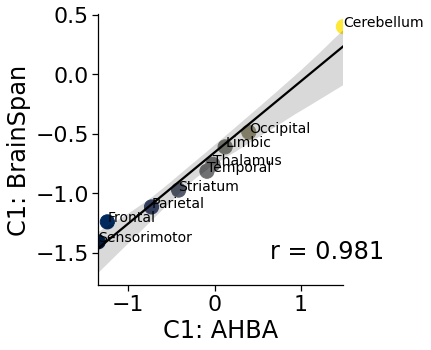

r = 0.953, p = 0.0


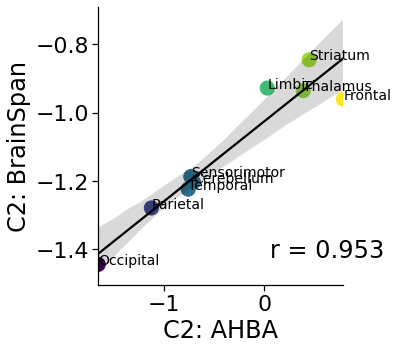

r = 0.913, p = 0.001


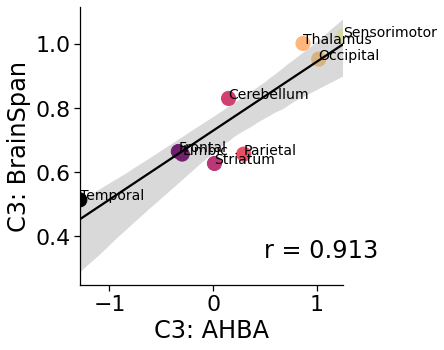

In [30]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],# just the adults!
                          values='zC%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'BS_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(fig_dir,'BrSp_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

In [33]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [41]:
# build a summary dataframe at the indexed by subjects

cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[gpdfs[1].index].values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

r=0.738, p=0.0


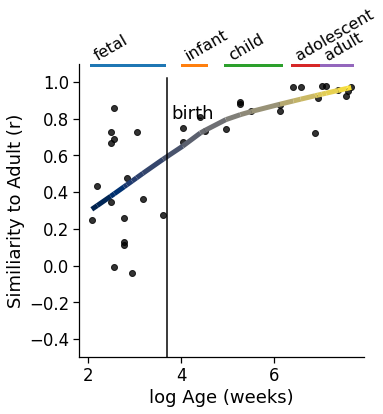

r=0.794, p=0.0


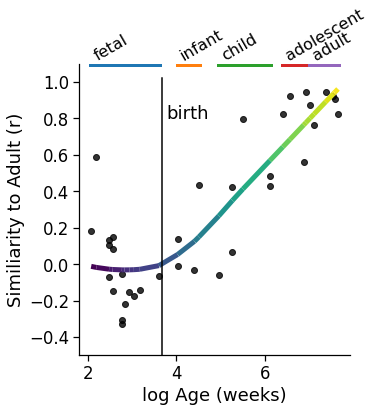

r=0.616, p=0.0001


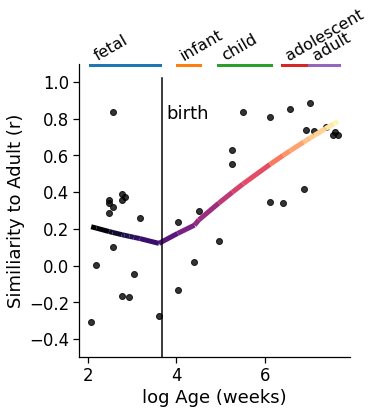

In [43]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

sns.set_context('notebook',font_scale=1.5)
# for each component
for c in range(1,(n_comps+1)):
    # plot
    g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
    # make line purty
    x, y = g.ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    g.ax.get_lines()[0].remove()
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.5,1.1)
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.8,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



# Run new analysis

In [61]:
ss = pandas.DataFrame(index=gdf.donor_id.unique())
for col in cols:
    ss.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[ss.index].values
for c in range(1,4):
    print('_____WORKING ON C%s_____'%c)
    # Get a tiny C2 dataframe
    jnk = pandas.DataFrame(gxp.T,copy=True)
    for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
        jnk.loc[:,col] = gdf[col].values

    # load Allen Brain Atlas data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']

    # create a summary dataframe and add columns
    ## NOTE!! THIS CODE HAD A BUG! IS NOW FIXED BUT HASNT BEEN RERUN
    

    # iterage through all genes
    gpdf = jnk[['donor_id','C%s_exp'%c,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%c).loc[ss.index]
    gpdf.drop('GangEm',axis=1,inplace=True)
    # count how many instances (i.e. regions) have valid (not NaN) entries
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]

    fail = False
    # iterate through the subjects
    for i,row in gpdf.iterrows():
        # find out correlation of gene with AHBA C2 for each subject
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5: # only if 6+ valid entries
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # get non-parametric in case reviewer asks
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            gpdf.loc[i,'%s_r'%c] = r
            gpdf.loc[i,'%s_rho'%c] = rho
        # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
    ss.loc[:,'C%s_r'%c] = gpdf.loc[ss.index,'%s_r'%c].values
    ss.loc[:,'C%s_rho'%c] = gpdf.loc[ss.index,'%s_rho'%c].values
    ss.loc[:,'n_valid'] = gpdf.loc[ss.index,'n_valid'].values
        

_____WORKING ON C1_____
_____WORKING ON C2_____
_____WORKING ON C3_____


In [62]:
ss.columns

Index(['donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'Age_Stage', 'Age_Epoch',
       'Age_Period', 'MacroStructure', 'MacroStructure2', 'NT_Segment',
       'Sensorifugal', 'age_level', 'age_in_months', 'log_age_months',
       'age_in_weeks', 'log_age_weeks', 'C1_r', 'C1_rho', 'n_valid', 'C2_r',
       'C2_rho', 'C3_r', 'C3_rho'],
      dtype='object')

In [64]:
gxp

,1,2,3,4,5,6,7,8,9,10,...,515,516,517,518,519,520,521,522,523,524
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC35G6,0.030182,0.000000,0.000000,0.000000,0.000000,0.014825,0.000000,0.018457,0.037863,0.000000,...,0.000000,0.000000,0.000000,0.073606,0.038930,0.000000,0.000000,0.000000,0.041004,0.000000
GH1,0.000000,0.000000,0.000000,0.080715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.067709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
THTPA,10.625217,9.690860,11.201571,12.094830,10.376242,9.327033,9.917661,12.783277,12.309605,13.032196,...,16.194193,17.851944,10.693976,9.858799,10.030765,8.465200,17.267813,21.401409,12.375088,16.954387
ANP32AP1,41.935201,52.451933,35.506476,35.755697,38.726738,22.715802,50.156694,24.878772,62.633439,45.910084,...,3.070396,6.665558,6.178132,8.843410,9.073810,7.484486,4.270775,2.020416,10.126426,3.915770


In [65]:
# Get the significant C2 genes
alltopgenes = []
for c in range(1,4):
    perc = 0.025 / 3
    thresh = int(round(comps.shape[0] * perc))
    # genes = comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[-thresh:].index.tolist()
    # genes += comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[:thresh].index.tolist()
    genes = comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
    genes += comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
    alltopgenes += genes

In [72]:
for c in range(1,4):
    print('_____WORKING ON C%s_____'%c)
    # Get a tiny C2 dataframe
    jnk = pandas.DataFrame(gxp.T,copy=True)
    for col in ['donor_id','MacroStructure2','C%s_exp'%c]:
        jnk.loc[:,col] = gdf[col].values

    # load Allen Brain Atlas data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']

    # create a summary dataframe and add columns
    ## NOTE!! THIS CODE HAD A BUG! IS NOW FIXED BUT HASNT BEEN RERUN
    subsum = pandas.DataFrame(index=gdf.donor_id.unique())
    for col in cols:
        subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

    # iterage through all genes
    for it,gene in enumerate(gxp.index):
        # keep track, while making sure the first few runs work before going forward
        if it == 100:
            print('first 100')
        if it % 1000 == 0:
            print('working on %s of %s'%((it+1),len(gxp)))
        if gene not in np.unique(alltopgenes): continue # IF DOING ONLY TOP GENES
        if '%s_r'%gene in subsum.columns: continue
        # make a subject x expression dataframe for the gene
        gpdf = jnk[['donor_id',gene,'MacroStructure2']
                      ].set_index(['donor_id'],append=True
                                 ).pivot_table(index='donor_id',
                                               columns='MacroStructure2',
                                               values=gene).loc[subsum.index]
        gpdf.drop('GangEm',axis=1,inplace=True)
        # count how many instances (i.e. regions) have valid (not NaN) entries
        for ind,row in gpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            gpdf.loc[ind,'n_valid'] = n_valid
        aba = aba.loc[gpdf.columns[:-1]]

        fail = False
        # iterate through the subjects
        for i,row in gpdf.iterrows():
            # find out correlation of gene with AHBA C2 for each subject
            forcorr = pandas.DataFrame(aba,copy=True)
            if row['n_valid'] > 5: # only if 6+ valid entries
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                    fail = True
                    continue
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                # get non-parametric in case reviewer asks
                rho = stats.spearmanr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                gpdf.loc[i,'%s_r'%gene] = r
                gpdf.loc[i,'%s_rho'%gene] = rho
        # store per gene information for each subject -- r, rho and n_valid
        if fail == True: continue
        subsum.loc[:,'%s_r'%gene] = gpdf.loc[subsum.index,'%s_r'%gene].values
        subsum.loc[:,'%s_rho'%gene] = gpdf.loc[subsum.index,'%s_rho'%gene].values
        subsum.loc[:,'n_valid'] = gpdf.loc[subsum.index,'n_valid'].values
        
    subsum.to_csv('data/TESTBioInf_rvals_C%s_rotated.csv'%c)

_____WORKING ON C1_____
working on 1 of 13750
first 100
working on 1001 of 13750
working on 2001 of 13750
working on 3001 of 13750
working on 4001 of 13750
working on 5001 of 13750
working on 6001 of 13750
working on 7001 of 13750
working on 8001 of 13750
working on 9001 of 13750
working on 10001 of 13750
working on 11001 of 13750
working on 12001 of 13750
working on 13001 of 13750
_____WORKING ON C2_____
working on 1 of 13750
first 100
working on 1001 of 13750
working on 2001 of 13750
working on 3001 of 13750
working on 4001 of 13750
working on 5001 of 13750
working on 6001 of 13750
working on 7001 of 13750
working on 8001 of 13750
working on 9001 of 13750
working on 10001 of 13750
working on 11001 of 13750
working on 12001 of 13750
working on 13001 of 13750
_____WORKING ON C3_____
working on 1 of 13750
first 100
working on 1001 of 13750
working on 2001 of 13750
working on 3001 of 13750
working on 4001 of 13750
working on 5001 of 13750
working on 6001 of 13750
working on 7001 of 13750

In [52]:
#subsum.to_csv('data/BioInf_rvals_C3_rotated.csv')

In [299]:
subsum = pandas.read_csv('data/TESTBioInf_rvals_C1_rotated.csv',index_col=0)

In [300]:
# Get the significant C2 genes
c=1
perc = 0.025 / 3
thresh = int(round(comps.shape[0] * perc))
# genes = comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[-thresh:].index.tolist()
# genes += comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[:thresh].index.tolist()
genes = comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C1']

In [301]:
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


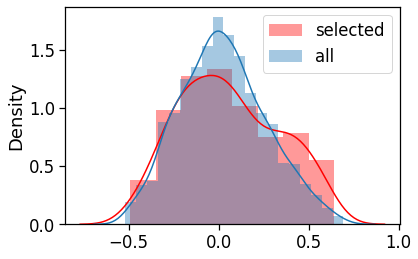

In [302]:
stat = 'r' # can change this to rho if desired
selected = subsum[['%s_%s'%(x,stat) for x in genes if x in topgenes.C1.values and\
                                                     '%s_%s'%(x,stat) in subsum.columns]
                 ].mean()
allrs = subsum[[x for x in subsum.columns if '_%s'%stat in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

In [303]:
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C1.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

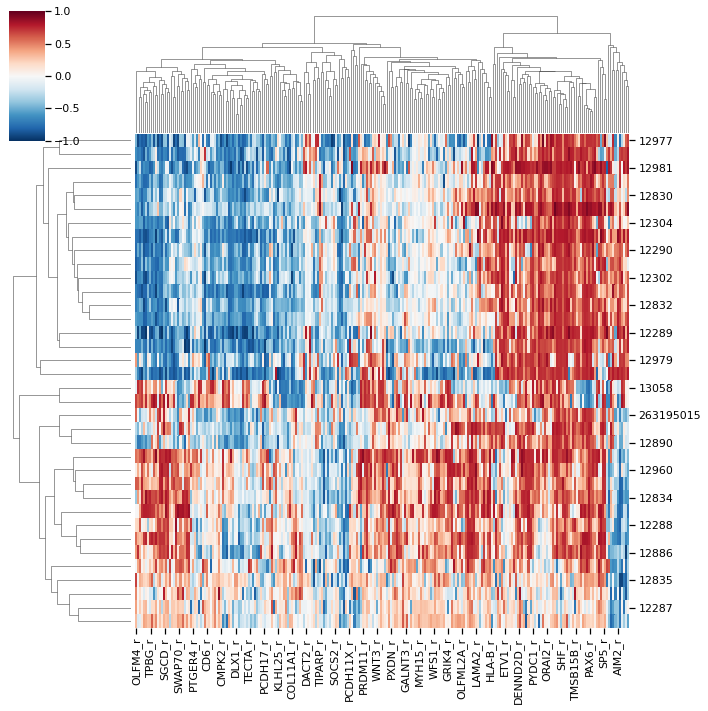

In [304]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss,center=0,vmin=-1,vmax=1,cmap='RdBu_r')

In [80]:
list(zip(g.data2d.index,subsum.loc[g.data2d.index].age.values))

[(12977, '10 mos'),
 (12836, '3 yrs'),
 (12981, '8 yrs'),
 (12841, '8 yrs'),
 (12830, '1 yrs'),
 (12298, '4 yrs'),
 (12304, '40 yrs'),
 (12300, '23 yrs'),
 (12290, '30 yrs'),
 (12303, '37 yrs'),
 (12302, '36 yrs'),
 (12831, '13 yrs'),
 (12832, '19 yrs'),
 (13057, '21 yrs'),
 (12289, '11 yrs'),
 (12984, '18 yrs'),
 (12979, '2 yrs'),
 (12980, '3 yrs'),
 (13058, '8 pcw'),
 (12833, '9 pcw'),
 (263195015, '37 pcw'),
 (12296, '4 mos'),
 (12890, '4 mos'),
 (12888, '13 pcw'),
 (12960, '12 pcw'),
 (13060, '12 pcw'),
 (12834, '13 pcw'),
 (12837, '16 pcw'),
 (12288, '24 pcw'),
 (12880, '17 pcw'),
 (12886, '21 pcw'),
 (12820, '13 pcw'),
 (12835, '12 pcw'),
 (12879, '16 pcw'),
 (12287, '16 pcw'),
 (12885, '19 pcw')]

In [81]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

In [83]:
csol

,k,sil_score,ch_score
0,2.0,0.292664,119.015067
1,3.0,0.154958,82.218900
2,4.0,0.163149,65.466086
3,5.0,0.143221,57.496957
4,6.0,0.138916,50.524960
5,7.0,0.105391,45.330989
6,8.0,0.103686,41.787807
7,9.0,0.090641,38.266267
8,10.0,0.088658,35.415280
9,11.0,0.083153,33.128478


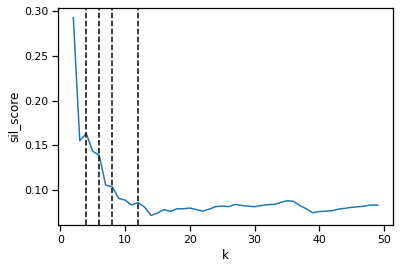

In [85]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [4,6,8,12]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

<AxesSubplot:>

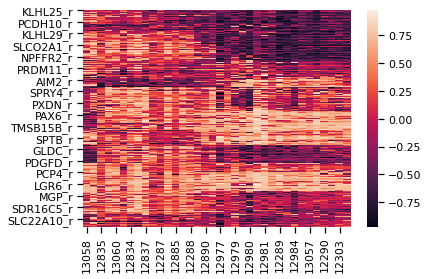

In [305]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [141]:
c2ss.to_csv('data/BSDevGens_C1_ss_4clus.csv')

In [285]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

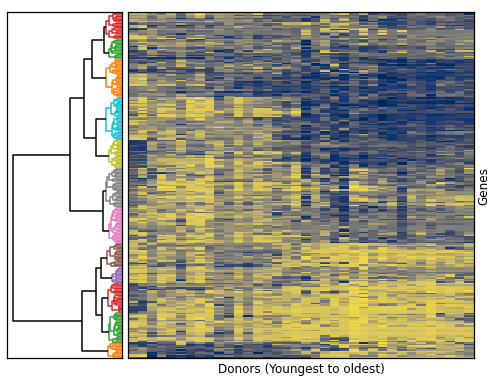

In [306]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=6,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="cividis",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

#plt.savefig(os.path.join(fig_dir,'EGenes_DendoC1_4clus.pdf'),bbox_inches='tight')
plt.show()

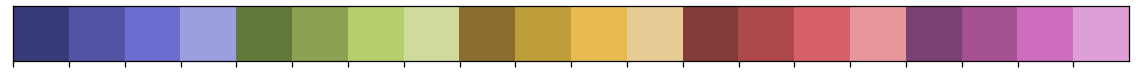

In [315]:
sns.palplot(sns.color_palette('tab20b'))
plt.savefig(os.path.join(fig_dir,'CPalette.pdf'),bbox_inches='tight')

In [146]:
data.loc['PAX6_r']['labels']

1.0

In [147]:
data[data.labels==1]

,13058,12833,12835,12960,13060,12820,12834,12888,12287,12837,...,12831,12984,12832,13057,12300,12290,12302,12303,12304,labels
WFDC1_r,0.645457,0.777607,0.358735,0.767372,0.357797,0.455393,0.564014,0.772158,0.353304,0.324171,...,0.489527,0.491603,0.602638,0.722274,0.748023,-0.544892,-0.026927,0.693268,-0.475229,1
AMDHD1_r,0.116174,0.532758,0.053341,0.398563,0.368040,0.063574,0.591644,0.059071,-0.080480,0.307070,...,0.539577,0.759757,0.545468,0.521148,0.599205,0.446294,0.492008,0.548335,0.617114,1
ONECUT2_r,0.718400,0.697195,0.238083,0.449827,0.399066,0.052055,0.323336,0.529112,-0.022282,0.032280,...,-0.121066,0.007355,-0.099479,-0.112453,-0.089412,-0.144027,-0.086305,-0.183494,-0.135030,1
GDF10_r,0.767602,0.804086,0.072227,0.761319,0.741275,0.139185,0.745994,0.740729,-0.672723,0.736233,...,0.632359,0.667855,0.509526,0.497361,0.827890,-0.145794,0.318549,0.444873,-0.442314,1
DENND2D_r,0.407592,0.655551,-0.185090,0.353966,0.107523,0.022647,0.316487,-0.216208,0.253954,0.765929,...,0.602913,0.719705,0.406371,0.280407,0.570823,0.334832,0.116920,0.076917,-0.324288,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGDCC3_r,0.587003,0.468588,0.284146,0.401124,0.318553,0.368466,0.635261,0.715453,-0.141025,0.515482,...,0.611918,0.588052,0.805975,0.690043,0.725657,0.849470,0.573370,0.752485,0.849296,1
BDKRB2_r,-0.439087,-0.206724,-0.559737,0.653476,0.258168,0.361862,0.408434,0.359188,0.235335,0.660952,...,0.265416,0.747655,0.767196,0.443549,0.789148,0.774955,0.655504,0.634375,0.658389,1
ARL9_r,0.681880,0.611599,-0.067117,0.200431,0.197947,0.013035,0.301999,0.182495,-0.036654,-0.209302,...,0.366989,-0.254694,0.126669,0.103228,-0.143480,0.348085,-0.022594,0.020260,0.460504,1
ST3GAL6_r,0.297729,0.537874,0.191604,0.783508,0.600566,-0.603428,0.441519,0.619020,-0.009568,-0.335551,...,0.407428,0.497675,0.178393,0.494355,0.629727,-0.037118,0.047667,0.579014,-0.052661,1


In [319]:
jnk = pandas.DataFrame(data.T.loc[data.columns[:-1]],copy=True)
jnk.loc[:,'log_age_weeks'] = subsum.loc[jnk.index,'log_age_weeks'].values

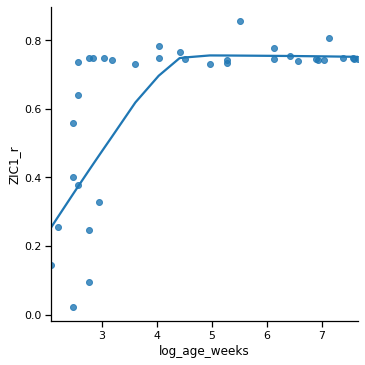

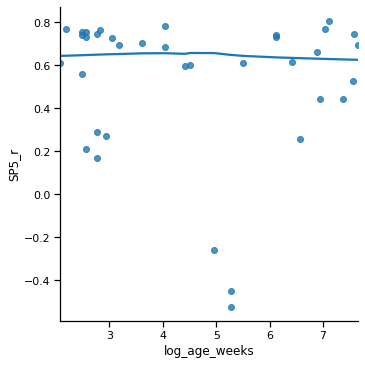

In [322]:
for gene in ['ZIC1_r','SP5_r']:
    sns.lmplot(x='log_age_weeks',y=gene,data=jnk,lowess=True)

In [160]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,...,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks,CYP26B1_r
13058,0.056134,0.319605,0.140397,-0.035286,-0.173570,-0.330594,0.429760,-0.537206,0.585112,0.458994,...,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442,0.724765
12833,0.153570,0.490703,0.218691,-0.008314,0.160093,-0.292014,0.410751,-0.489052,0.644366,0.507671,...,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225,0.720514
12835,-0.071293,0.180757,0.065193,-0.521604,0.082317,0.194603,0.088788,0.193391,0.223098,0.140186,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.184026
12960,-0.019011,0.375712,0.130570,-0.297983,0.496757,0.281168,0.229346,0.089666,0.611336,0.563474,...,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.732659
13060,-0.107446,0.409937,0.086346,-0.482986,0.409204,0.286580,0.173532,0.249074,0.523357,0.530825,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.800932


In [161]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())

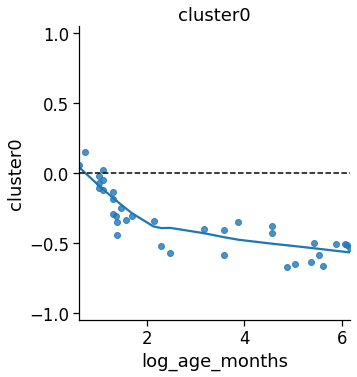

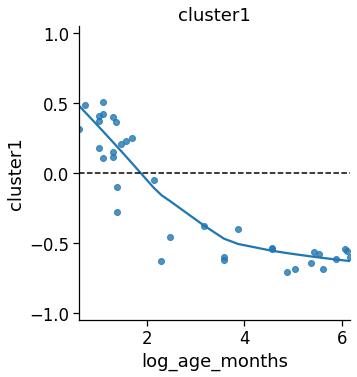

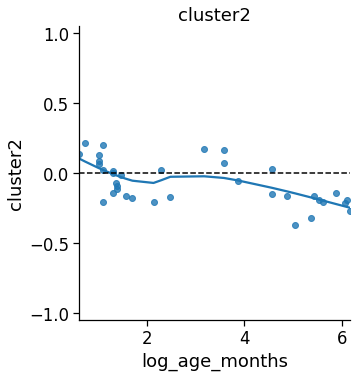

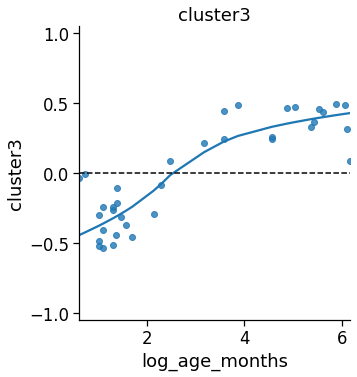

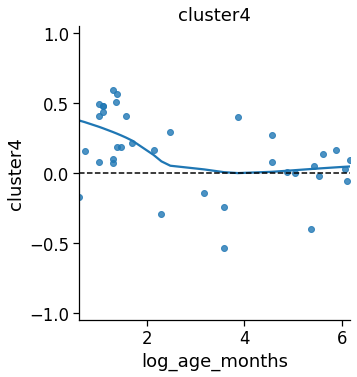

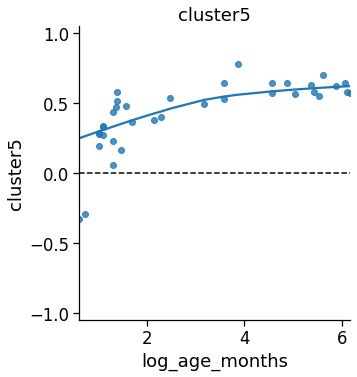

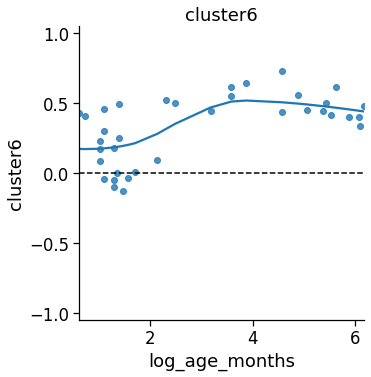

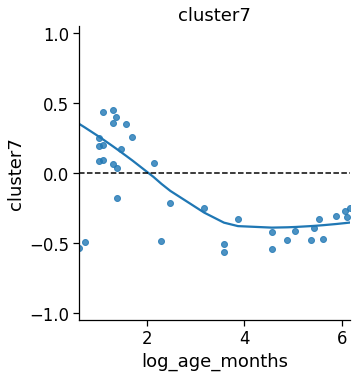

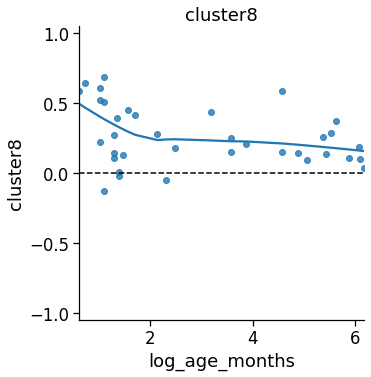

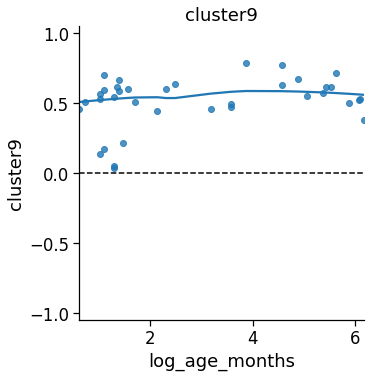

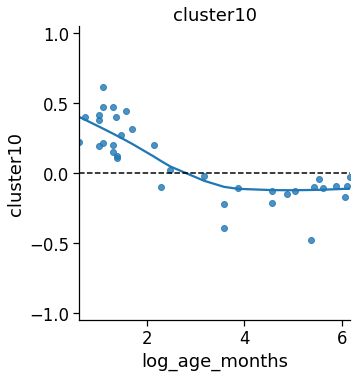

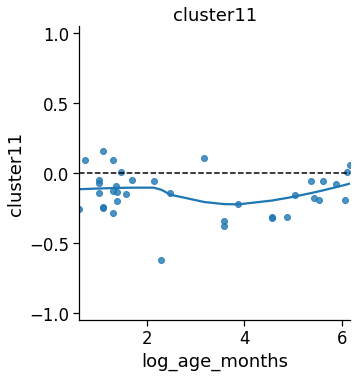

In [162]:
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

In [165]:
data.iloc[idx1].labels.values

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  2

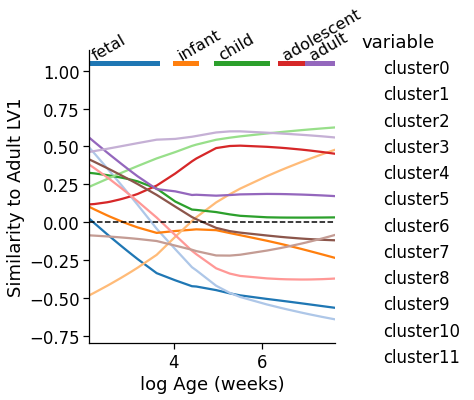

In [164]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In [152]:
#tall.to_csv('data/BSDevGens_C1_4clus.csv')

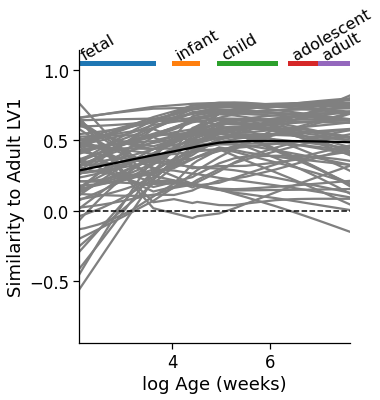

In [154]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==1].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster1.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_4Clus_1.pdf'),
            bbox_inches='tight')

In [134]:
# replicated = ['NEB', 'PAX6', 'GLCE', 'BEND7', 'GRM4', 'TSHZ1', 'HELLS', 'GALNT7',
#               'TLL1', 'LIMK2']
replicated = ['SPON2', 'SP5', 'ZIC1', 'TLL1', 'C14orf132', 'LIMK2', 'LGR6',
       'CCDC88B']

In [127]:
c5plots.iloc[:,:-2].mean(0).sort_values(ascending=False)

CCDC88B_r      0.642624
ZIC1_r         0.629708
TLL1_r         0.624967
GRM4_r         0.587321
C14orf132_r    0.587209
TP53AIP1_r     0.564657
LIMK2_r        0.550691
SPON2_r        0.527477
SP5_r          0.526077
PYDC1_r        0.524545
LGR6_r         0.517217
IGDCC3_r       0.508967
SHF_r          0.508561
TSPAN33_r      0.484391
SPTBN5_r       0.465660
LAMB1_r        0.460015
VIT_r          0.457751
GDF10_r        0.425862
DENND2D_r      0.418515
ADAMTS2_r      0.410634
HLA-J_r        0.376559
dtype: float64

### See if the C1 genes replicate in other datasets

In [131]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
ccode = dict(zip(range(12),['rising_negative','reversing_negative','slight_reversing',
                             'reversing_positive','falling','early_rising','middle_rising',
                             'reversing_negative2','partially_falling','non-transitional',
                             'falling2','irrelevant_throughout']))
c1labs.loc[:,'name'] = [ccode[x] for x in c1labs.Cluster.values]
c1labs.to_csv('data/C1_devclusters.csv')

In [155]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
ccode = dict(zip(range(4),['rising_negative','non-transitional',
                            'falling','reversing_positive',]))
c1labs.loc[:,'name'] = [ccode[x] for x in c1labs.Cluster.values]
c1labs.to_csv('data/C1_devclusters_4clus.csv')

# C2

In [342]:
subsum = pandas.read_csv('data/TESTBioInf_rvals_C2_rotated.csv',index_col=0)

In [343]:
# Get the significant C2 genes
c=2
perc = 0.025 / 3
thresh = int(round(comps.shape[0] * perc))
# genes = comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[-thresh:].index.tolist()
# genes += comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[:thresh].index.tolist()
genes = comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C2']

In [346]:
'ANK1' in topgenes.C2.values

False

In [337]:
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


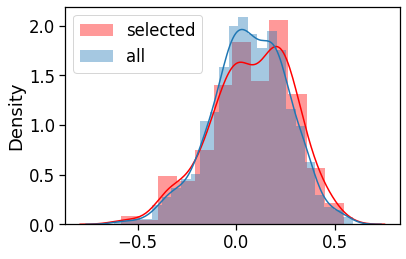

In [208]:
stat = 'r' # can change this to rho if desired
selected = subsum[['%s_%s'%(x,stat) for x in genes if x in topgenes.C2.values and\
                                                     '%s_%s'%(x,stat) in subsum.columns]
                 ].mean()
allrs = subsum[[x for x in subsum.columns if '_%s'%stat in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

In [338]:
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C2.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

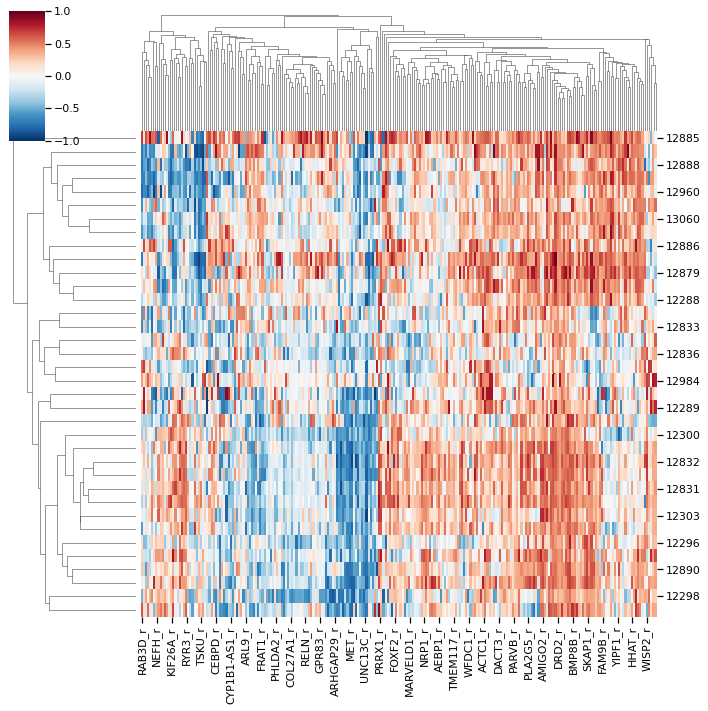

In [210]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss,center=0,vmin=-1,vmax=1,cmap='RdBu_r')

In [211]:
list(zip(g.data2d.index,subsum.loc[g.data2d.index].age.values))

[(12885, '19 pcw'),
 (12820, '13 pcw'),
 (12888, '13 pcw'),
 (12835, '12 pcw'),
 (12960, '12 pcw'),
 (12837, '16 pcw'),
 (13060, '12 pcw'),
 (12834, '13 pcw'),
 (12886, '21 pcw'),
 (12287, '16 pcw'),
 (12879, '16 pcw'),
 (12880, '17 pcw'),
 (12288, '24 pcw'),
 (13058, '8 pcw'),
 (12833, '9 pcw'),
 (12979, '2 yrs'),
 (12836, '3 yrs'),
 (12980, '3 yrs'),
 (12984, '18 yrs'),
 (12981, '8 yrs'),
 (12289, '11 yrs'),
 (263195015, '37 pcw'),
 (12300, '23 yrs'),
 (13057, '21 yrs'),
 (12832, '19 yrs'),
 (12290, '30 yrs'),
 (12831, '13 yrs'),
 (12302, '36 yrs'),
 (12303, '37 yrs'),
 (12304, '40 yrs'),
 (12296, '4 mos'),
 (12977, '10 mos'),
 (12890, '4 mos'),
 (12830, '1 yrs'),
 (12298, '4 yrs'),
 (12841, '8 yrs')]

In [212]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

In [213]:
csol

,k,sil_score,ch_score
0,2.0,0.187089,61.075054
1,3.0,0.148578,51.703599
2,4.0,0.119646,41.458034
3,5.0,0.097636,35.073676
4,6.0,0.074134,31.117020
5,7.0,0.078372,27.891195
6,8.0,0.075564,25.564139
7,9.0,0.077608,23.521723
8,10.0,0.069703,21.967746
9,11.0,0.073552,20.640364


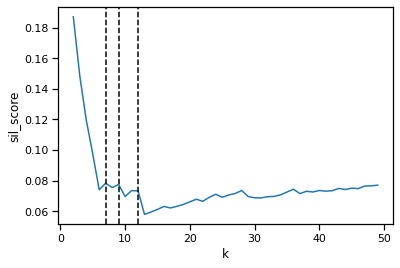

In [217]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [7,9,12]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

<AxesSubplot:>

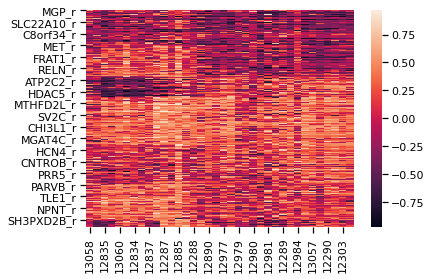

In [339]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [200]:
#c2ss.loc[:,'log_age_weeks'] = subsum.loc[c2ss.index,'log_age_weeks']

In [219]:
c2ss.to_csv('data/BSDevGens_C2_ss_7clus.csv')

In [220]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

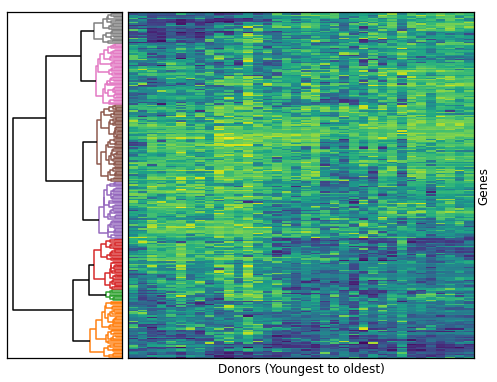

In [224]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=6.5,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="viridis",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

plt.savefig(os.path.join(fig_dir,'EGenes_DendoC2_7clus.pdf'),bbox_inches='tight')
plt.show()

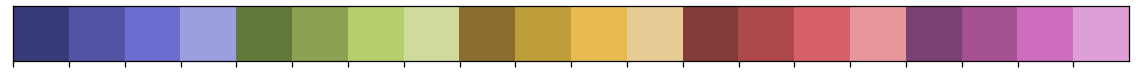

In [315]:
sns.palplot(sns.color_palette('tab20b'))
plt.savefig(os.path.join(fig_dir,'CPalette.pdf'),bbox_inches='tight')

In [340]:
jnk = pandas.DataFrame(data.T.loc[data.columns[:-1]],copy=True)
jnk.loc[:,'log_age_weeks'] = subsum.loc[jnk.index,'log_age_weeks'].values

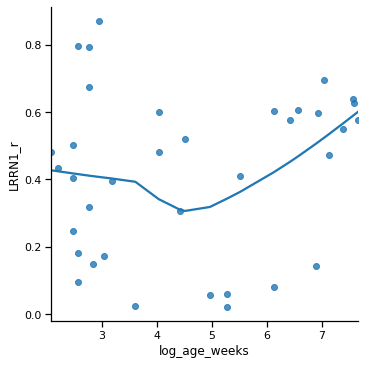

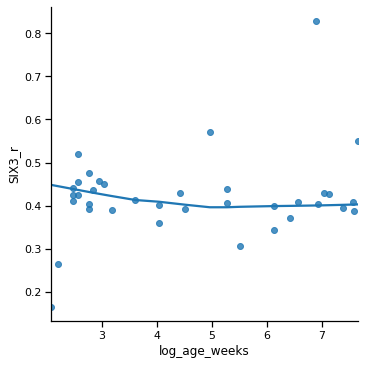

In [341]:
for gene in ['LRRN1_r','SIX3_r']:
    sns.lmplot(x='log_age_weeks',y=gene,data=jnk,lowess=True)

In [238]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,donor_id,donor_name,age,...,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks,CYP26B1_r
13058,-0.084519,0.024197,-0.222004,0.169684,0.027162,0.170094,-0.047282,13058,H376.IIA.51,8 pcw,...,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442,-0.119977
12833,-0.176794,0.006661,-0.250638,0.128818,-0.021786,0.207194,-0.510602,12833,H376.IIA.50,9 pcw,...,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225,-0.085578
12835,-0.349043,0.229076,-0.624491,0.352181,-0.085522,0.428138,-0.380977,12835,H376.IIB.50,12 pcw,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,-0.760905
12960,-0.247817,0.159012,-0.563803,0.254141,-0.086976,0.339731,-0.224025,12960,H376.IIB.51,12 pcw,...,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907,-0.219722
13060,-0.090620,0.180365,-0.356205,0.357387,0.107326,0.400679,0.102176,13060,H376.IIB.52,12 pcw,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,-0.276773


In [239]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())

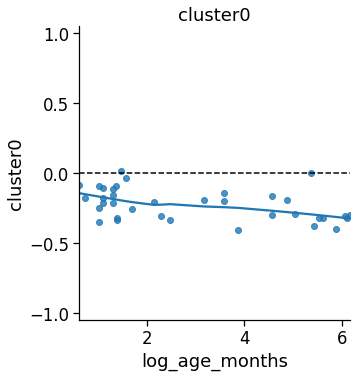

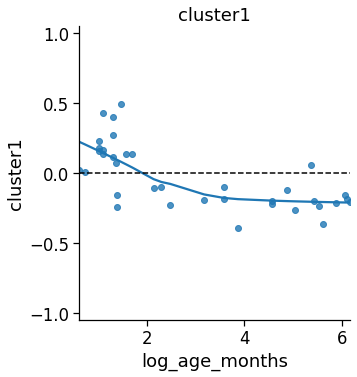

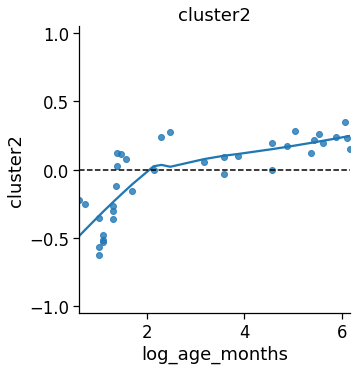

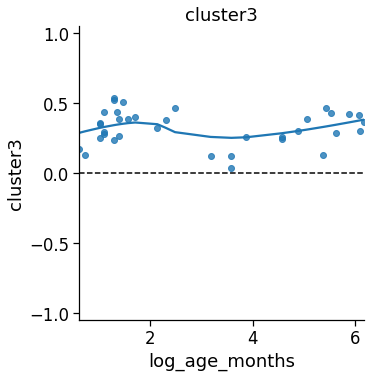

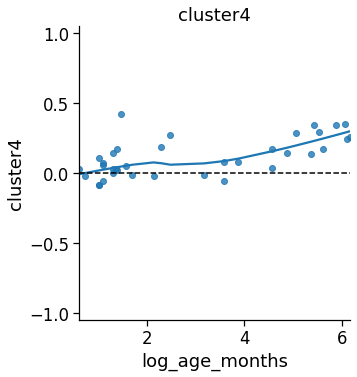

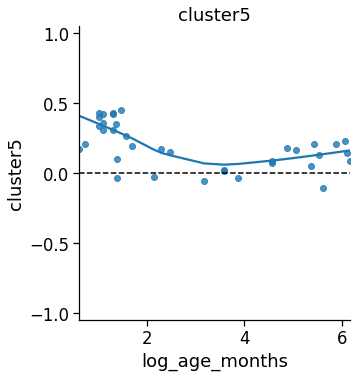

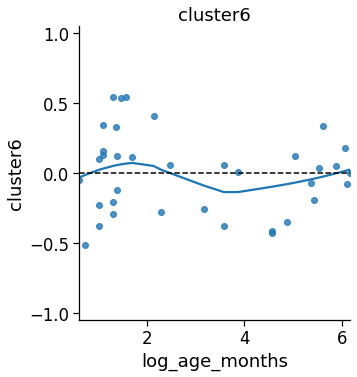

In [240]:
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

In [165]:
data.iloc[idx1].labels.values

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  2

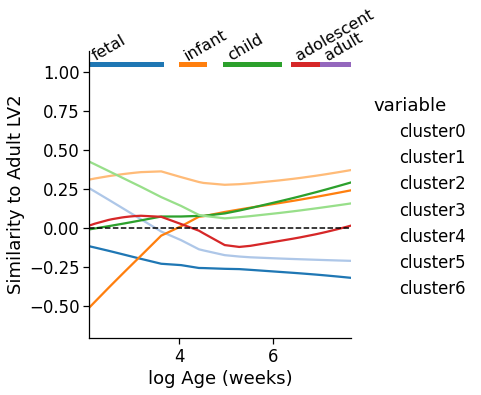

In [243]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines.pdf'),bbox_inches='tight')

In [242]:
tall.to_csv('data/BSDevGens_C2_7clus.csv')

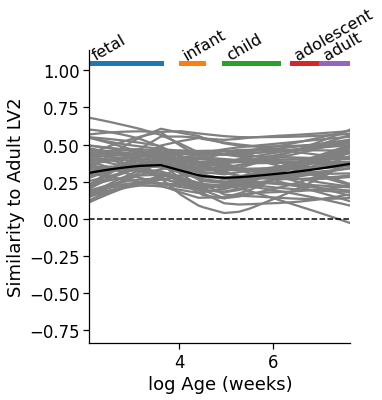

In [246]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==3].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster3.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_7Clus_3.pdf'),
            bbox_inches='tight')

In [247]:
# # plot the trajectory of all genes in cluster 5

# c5plots = pandas.DataFrame(data[data.labels==5].T,copy=True)
# c5plots.drop('labels',inplace=True)
# c5plots.loc[:,'ind'] = range(len(c5plots))
# c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
# gtall = pandas.melt(c5plots,id_vars='ind',
#                    value_vars=[x for x in c5plots.columns if '_r' in x])
# gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

# sns.set_context('notebook',font_scale=1.5)
# g=sns.lmplot(x='log_age_weeks',y='value',
#             hue='variable',lowess=True,
#              markers='',#palette='tab10',
#              palette=['gray']*len(tall.variable.unique()),#palette=colors,
#              legend=None,
#              data=gtall)
# sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster5.values,color='black',
#            marker='',lowess=True)
# plt.ylabel('Similarity to Adult LV2')
# plt.xlabel('log Age (weeks)')

# for stage in gdf.Age_Stage.unique():
#     levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[1.05,1.05],lw=5)
#     plt.text(xmin,1.05,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
# plt.axhline(0,c='k',ls='--')
# plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_10Clus_5.pdf'),
#             bbox_inches='tight')

### See if the C2 genes replicate in other datasets

In [250]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
ccode = dict(zip(range(7),['non-transitional_neg','inverse_neg','inverse_pos',
                            'non_transitional_pos','rising','falling','irrelevant']))
c1labs.loc[:,'name'] = [ccode[x] for x in c1labs.Cluster.values]
c1labs.to_csv('data/C2_devclusters.csv')

In [196]:
c1labs.Cluster.value_counts()

0    43
6    40
5    37
3    33
2    24
4    16
9    16
1    15
8    11
7     8
Name: Cluster, dtype: int64

# C3

In [251]:
subsum = pandas.read_csv('data/TESTBioInf_rvals_C3_rotated.csv',index_col=0)

In [252]:
# Get the significant C2 genes
c=3
perc = 0.025 / 3
thresh = int(round(comps.shape[0] * perc))
# genes = comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[-thresh:].index.tolist()
# genes += comps.sort_values('C%s'%c).dropna().gene_symbol.iloc[:thresh].index.tolist()
genes = comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[:thresh]
genes += comps.sort_values('C%s'%c).dropna().gene_symbol.tolist()[-thresh:]
topgenes = pandas.DataFrame(genes)
topgenes.columns = ['C3']

In [253]:
cols = ['donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level','age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[subsum.index].values

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


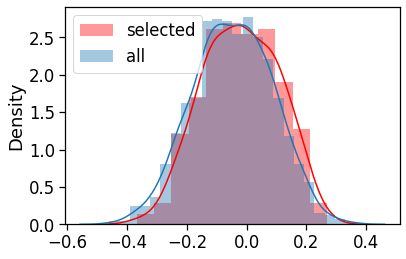

In [254]:
stat = 'r' # can change this to rho if desired
selected = subsum[['%s_%s'%(x,stat) for x in genes if x in topgenes.C3.values and\
                                                     '%s_%s'%(x,stat) in subsum.columns]
                 ].mean()
allrs = subsum[[x for x in subsum.columns if '_%s'%stat in x]].mean()
sns.distplot(selected,label='selected',color='red')
sns.distplot(allrs,label='all')
plt.legend()

In [255]:
c2ss = pandas.DataFrame(subsum[[x+'_r' for x in topgenes.C3.values if x+'_r' in subsum.columns]
                              ].dropna(),copy=True)
c2ss.drop([x for x in c2ss.index if all(~pandas.notnull(c2ss.loc[x]))],axis=0,inplace=True)
c2ss.drop([x for x in c2ss.columns if any(~pandas.notnull(c2ss.loc[:,x]))],axis=1,inplace=True)

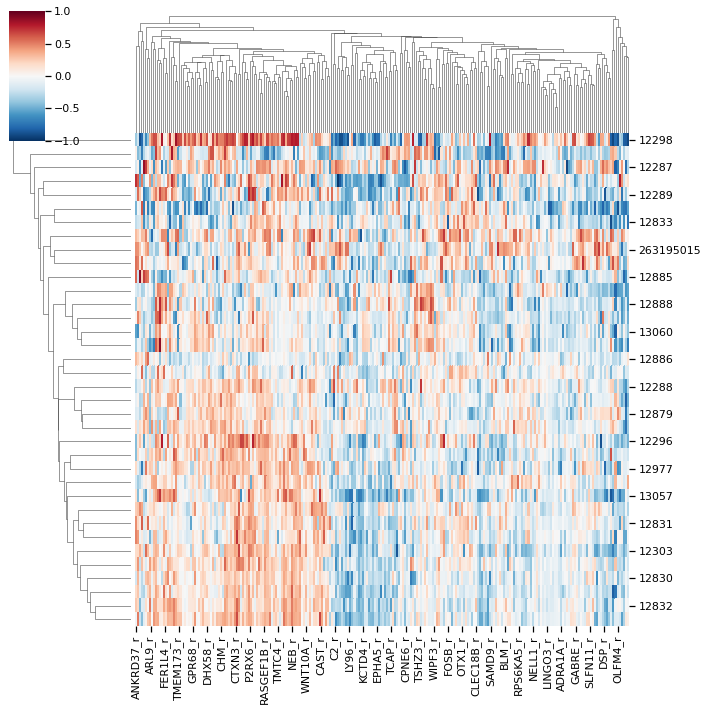

In [256]:
sns.set_context('notebook',font_scale=1)
g = sns.clustermap(c2ss,center=0,vmin=-1,vmax=1,cmap='RdBu_r')

In [257]:
list(zip(g.data2d.index,subsum.loc[g.data2d.index].age.values))

[(12298, '4 yrs'),
 (12820, '13 pcw'),
 (12287, '16 pcw'),
 (12981, '8 yrs'),
 (12289, '11 yrs'),
 (13058, '8 pcw'),
 (12833, '9 pcw'),
 (12979, '2 yrs'),
 (263195015, '37 pcw'),
 (12980, '3 yrs'),
 (12885, '19 pcw'),
 (12835, '12 pcw'),
 (12888, '13 pcw'),
 (12960, '12 pcw'),
 (13060, '12 pcw'),
 (12834, '13 pcw'),
 (12886, '21 pcw'),
 (12984, '18 yrs'),
 (12288, '24 pcw'),
 (12837, '16 pcw'),
 (12879, '16 pcw'),
 (12880, '17 pcw'),
 (12296, '4 mos'),
 (12890, '4 mos'),
 (12977, '10 mos'),
 (12836, '3 yrs'),
 (13057, '21 yrs'),
 (12304, '40 yrs'),
 (12831, '13 yrs'),
 (12300, '23 yrs'),
 (12303, '37 yrs'),
 (12841, '8 yrs'),
 (12830, '1 yrs'),
 (12302, '36 yrs'),
 (12832, '19 yrs'),
 (12290, '30 yrs')]

In [258]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,50)):
    #print('working on k =',k)
    d = c2ss.T.values
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

In [259]:
csol

,k,sil_score,ch_score
0,2.0,0.122377,40.592092
1,3.0,0.081910,30.712638
2,4.0,0.056842,24.461549
3,5.0,0.054999,21.548524
4,6.0,0.047833,18.933984
5,7.0,0.039691,17.118324
6,8.0,0.040010,15.816271
7,9.0,0.045549,14.879188
8,10.0,0.049009,14.077866
9,11.0,0.051821,13.387662


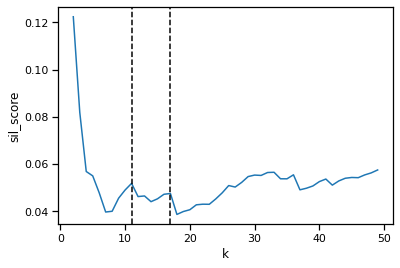

In [261]:
sns.lineplot(x='k',y='sil_score',data=csol)
peaks = [11,17]
for peak in peaks:
    plt.axvline(peak,ls='--',c='k')

<AxesSubplot:>

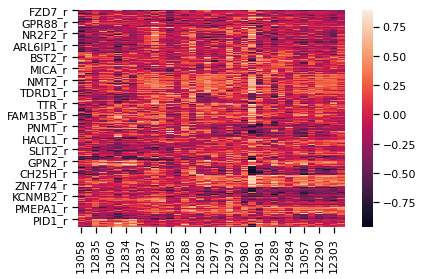

In [278]:
# cluster once more based on peak
cluster = AgglomerativeClustering(n_clusters=17, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(c2ss.T.values)
# sort data by cluster labels and plot
data = pandas.DataFrame(c2ss.T,copy=True)
data.loc[:,'labels'] = cluster.labels_
sorted_ind = [x for x in subsum.sort_values('log_age_weeks').index if x in data.columns]
sns.heatmap(data.sort_values('labels')[sorted_ind])

In [200]:
#c2ss.loc[:,'log_age_weeks'] = subsum.loc[c2ss.index,'log_age_weeks']

In [298]:
c2ss.to_csv('data/BSDevGens_C3_ss_17clus.csv')

In [285]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

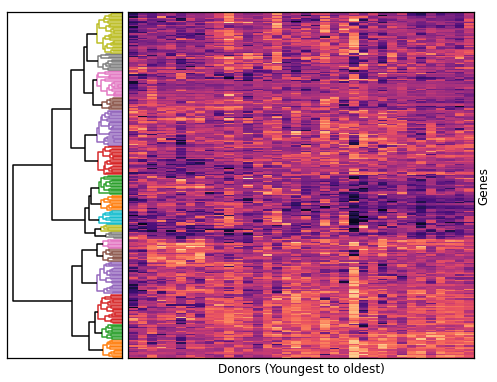

In [289]:
# Now make a version for visualization in the paper
import scipy.cluster.hierarchy as shc

# get the dendogram for the clustering solution
link = shc.linkage(c2ss.T.values, method='ward')
#dend = shc.dendrogram(link)

# get an index ordering that sorts by age
sorder = [x for x in subsum.sort_values('log_age_weeks').donor_id.values if x in c2ss.T.columns]

# define data
D = pandas.DataFrame(c2ss.T[sorder], copy=True)
D = D.values

# create dendogram
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = link
shc.set_link_color_palette(None)
Z1 = shc.dendrogram(Y, orientation='left',color_threshold=3.32,above_threshold_color='black',)
ax1.set_xticks([])
ax1.set_yticks([])

# main heat-map
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
D = D[idx1, :]
# the actual heat-map
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="magma",vmin=-1,vmax=1)

# decorate
axmatrix.set_xticks([])
axmatrix.set_yticks([])
axmatrix.yaxis.set_label_position('right')
plt.xlabel('Donors (Youngest to oldest)',)
plt.ylabel('Genes')

plt.savefig(os.path.join(fig_dir,'EGenes_DendoC3_17clus.pdf'),bbox_inches='tight')
plt.show()

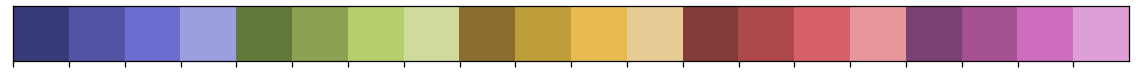

In [315]:
sns.palplot(sns.color_palette('tab20b'))
plt.savefig(os.path.join(fig_dir,'CPalette.pdf'),bbox_inches='tight')

In [290]:
cplots = data.groupby('labels').mean().T
cplots.columns = ['cluster%s'%x for x in cplots.columns]
for col in subsum.columns[:20]:
    cplots.loc[:,col] = subsum.loc[c2ss.index,col].values
cplots.head()

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,...,MacroStructure,MacroStructure2,NT_Segment,Sensorifugal,age_level,age_in_months,log_age_months,age_in_weeks,log_age_weeks,CYP26B1_r
13058,-0.282766,-0.442002,0.115120,-0.176990,-0.076860,-0.336975,-0.195055,-0.045219,-0.563767,0.038808,...,Occipital,Occipital,Tele,Association,0,1.839080,0.609266,8.0,2.079442,-0.122140
12833,-0.180360,-0.210266,0.150404,0.034252,-0.007237,-0.247519,-0.037608,-0.060194,-0.429780,0.110941,...,Frontal,Frontal,Tele,Association,1,2.068966,0.727049,9.0,2.197225,-0.049140
12835,0.065151,-0.250517,-0.101163,-0.118654,-0.238740,0.002008,0.116670,-0.217810,-0.588775,0.373860,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.512856
12960,-0.162589,-0.157636,0.052329,0.066585,-0.205436,-0.044699,-0.021773,-0.143991,-0.277913,0.400402,...,Temporal,Temporal,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.019723
13060,-0.065687,-0.140128,0.055769,0.084037,-0.127752,0.150599,-0.079783,-0.231738,-0.395117,0.201129,...,Limbic,Limbic,Tele,Association,2,2.758621,1.014731,12.0,2.484907,0.056141


In [291]:
# making plotting dataframe
cplots.loc[:,'ind'] = cplots.index
tall = pandas.melt(cplots,id_vars='ind',
                   value_vars=[x for x in cplots.columns if 'cluster' in x])
tall.loc[:,'log_age_weeks'] = cplots.log_age_weeks.tolist() * len(tall.variable.unique())

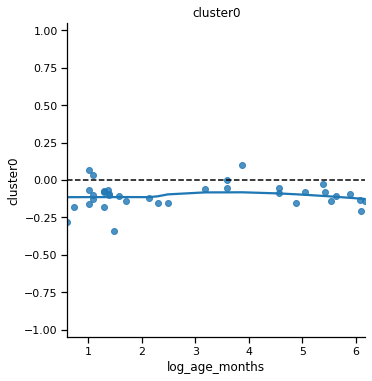

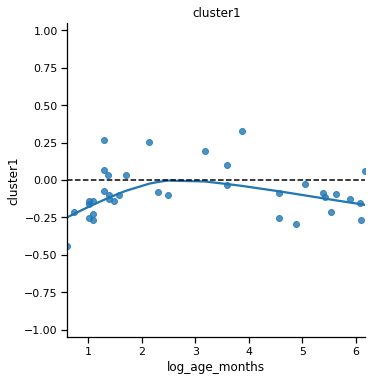

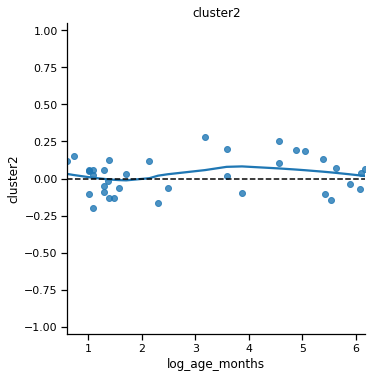

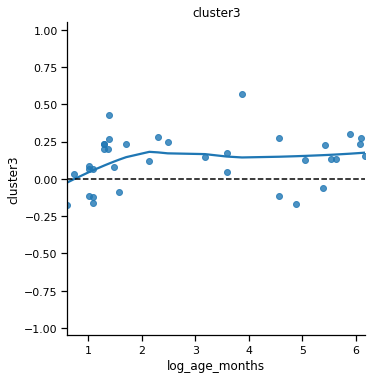

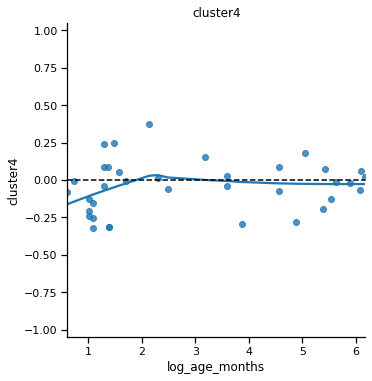

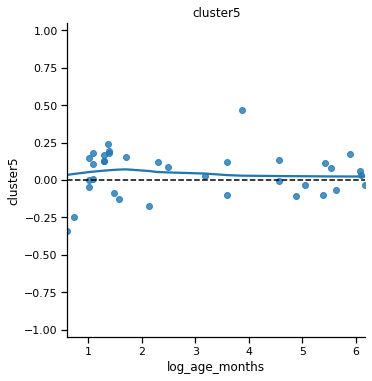

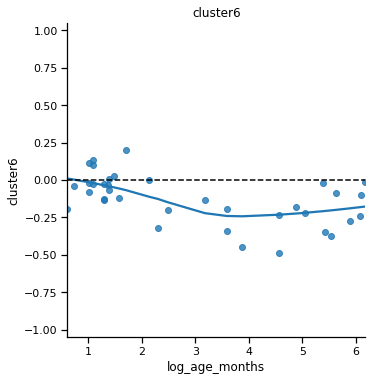

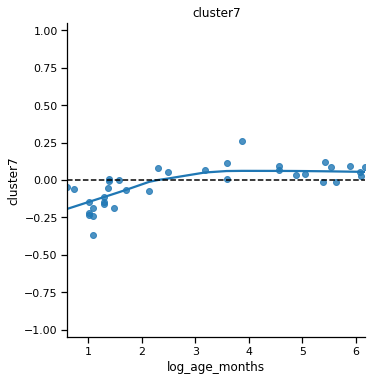

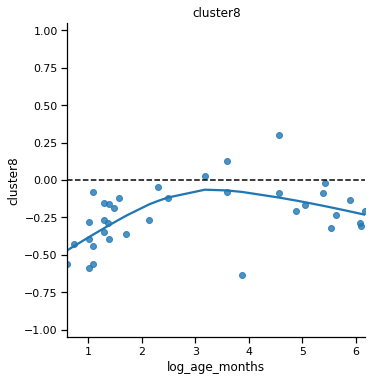

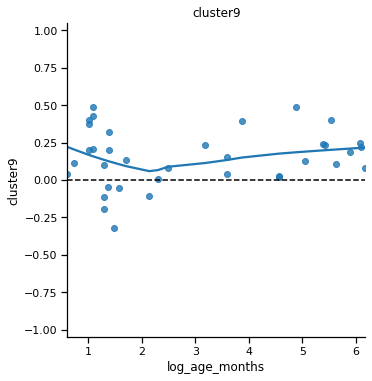

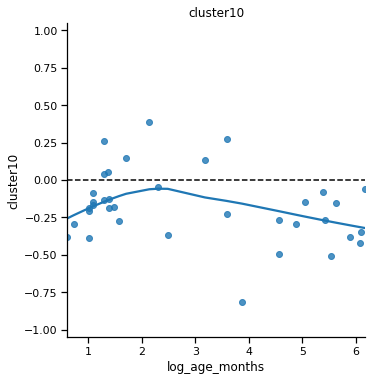

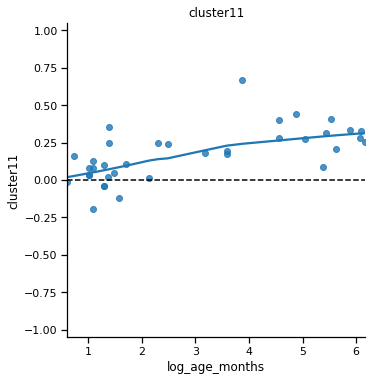

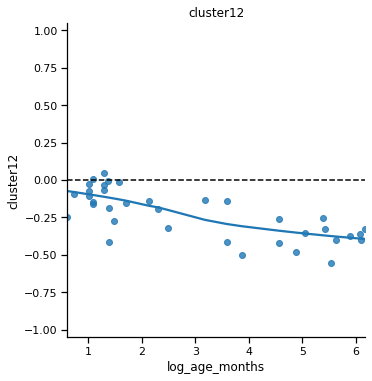

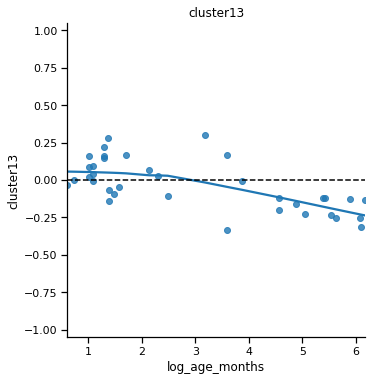

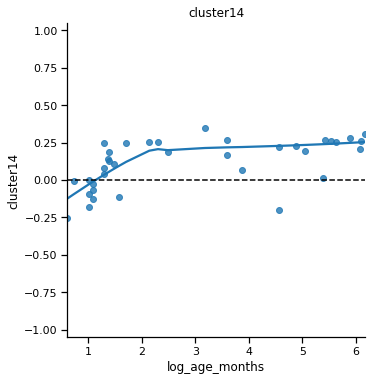

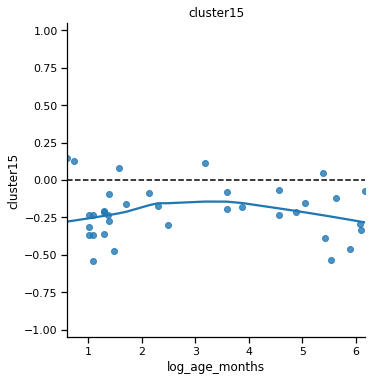

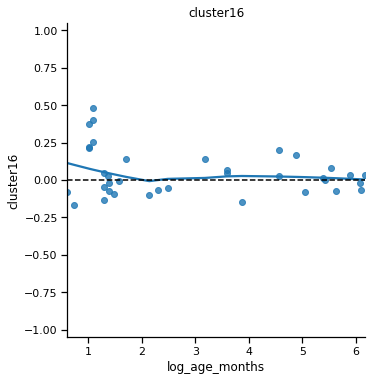

In [281]:
# for each cluster
for cluster in [x for x in cplots.columns if 'cluster' in x]:
    # plot expression over log age
    g=sns.lmplot(x='log_age_months',y=cluster,
            #hue='gender',
            lowess=True,
             #scatter_kws={'color':'k'},
           data=cplots)
    # decorate
    plt.ylim(-1.05,1.05)
    plt.axhline(0,ls='--',c='k')
    plt.title(cluster)
    plt.show()

In [165]:
data.iloc[idx1].labels.values

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  2

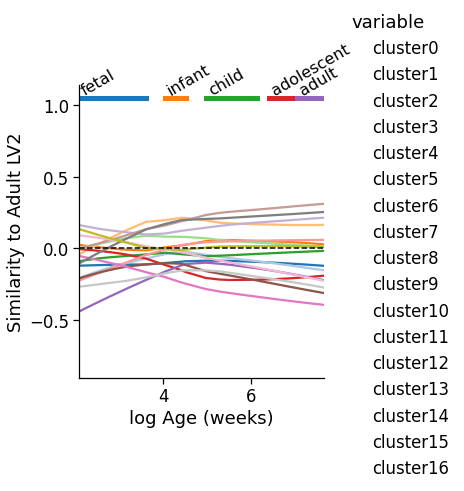

In [292]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines.pdf'),bbox_inches='tight')

In [297]:
tall.to_csv('data/BSDevGens_C3_17clus.csv')

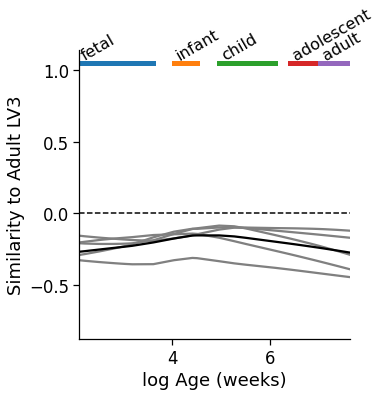

In [294]:
# plot the trajectory of all genes in cluster 5

c5plots = pandas.DataFrame(data[data.labels==15].T,copy=True)
c5plots.drop('labels',inplace=True)
c5plots.loc[:,'ind'] = range(len(c5plots))
c5plots.loc[:,'log_age_weeks'] = subsum.loc[c5plots.index,'log_age_weeks'].values
gtall = pandas.melt(c5plots,id_vars='ind',
                   value_vars=[x for x in c5plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c5plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(tall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=cplots.log_age_weeks.values,y=cplots.cluster15.values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines_17Clus_15.pdf'),
            bbox_inches='tight')

In [134]:
# replicated = ['NEB', 'PAX6', 'GLCE', 'BEND7', 'GRM4', 'TSHZ1', 'HELLS', 'GALNT7',
#               'TLL1', 'LIMK2']
replicated = ['SPON2', 'SP5', 'ZIC1', 'TLL1', 'C14orf132', 'LIMK2', 'LGR6',
       'CCDC88B']

### See if the C2 genes replicate in other datasets

In [295]:
c1labs = pandas.concat([pandas.Series([x.split('_')[0] for x in data.index]),
               pandas.Series(data.labels.values)],
              axis=1)
c1labs.columns = ['Gene','Cluster']
ccode = dict(zip(range(17),['nontransient_weakneg','earlydevvalley_neg','irrelevant',
                            'rising','neg_falling','irrelevant2','neg_rising','invert_pos',
                            'neg_falling2','earlydevvalley_pos','earlydevvalley_neg2',
                            'rising2','neg_rising2','invert_neg','rising3',
                            'nontransient_neg','falling']))
c1labs.loc[:,'name'] = [ccode[x] for x in c1labs.Cluster.values]
c1labs.to_csv('data/C3_devclusters.csv')

In [296]:
c1labs.Cluster.value_counts()

1     29
2     25
5     23
3     21
7     21
0     19
6     14
11    13
4     12
14    11
12    11
10    10
13     9
16     9
9      7
15     5
8      5
Name: Cluster, dtype: int64